In [1]:
import os
os.chdir('/home/david/Projects/optogenetic_whole_cell_activation/morph_impact_on_opt_stim')
import numpy as np
import pandas as pd
from neuron import h
from neurostim.cell import Cell
from neurostim.light_classes import LightSource, LightStimulation
from neurostim.utils import convert_polar_to_cartesian_xz, interpolate
from neurostim.polarmaps import get_AP_times
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import seaborn as sns
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Arial']})

In [2]:
# format
# dimensions (A4:  8.27 x 11.69 inches)
text_frac = 0.8
abs_pw = 8.27 # pagewidth
abs_pl = 11.69 # pagelength
pw = text_frac * abs_pw
pl = text_frac * abs_pl
# others
dpi=600

In [3]:
# simulate conductances in L5 cell for selected light powers
hoc_file = 'L5'
plot_path = 'paper/NEW_FIGURES/FIG1/plots/'+hoc_file+'_'

#light_powers = [5e-5, 1e-4, 5e-4, 1e-3, 5e-3]
light_powers = np.exp(np.linspace(np.log(1e-4), np.log(1e-2),10))
light_powers = np.linspace(1e-5, 1e-2,200)

In [4]:
# model config 1 ---- *** DO NOT RERUN ***
# NEURON simulator setup is corrupted if reinitialized in a running kernel, rerun complete notebook

# cortical depth of neuron models
cortical_depth = {'L23': 400, 'L5': 1170} #um

# ChR2 expression distribution and level
chanrhod_distribution = 'uniform' 
chanrhod_soma_density = 13e9

# NEURON setup
h.load_file("stdrun.hoc")
h.cvode_active(1)
# load cell and create stimulation object
cell = Cell(
    hoc_file="simneurostim/model/hoc/" + str(hoc_file) + ".hoc",
    cortical_depth=cortical_depth,
    ChR_soma_density=chanrhod_soma_density,
    ChR_distribution=str(chanrhod_distribution),
    delete_all_secs_except_soma=True
)

	1 
	1 
	1 
	1 


In [5]:
# model config 2 (can be adapted and rerun without restarting notebook kernel)

# light source model and params
light_model = 'foutz_et_al2012'
fiber_diameter = 200 #um
fiber_NA = 0.22
# stimulation duration
light_duration = 200 # ms
# other params
light_delay = 1 #ms
tot_rec_time = light_delay + light_duration + 10
AP_threshold = 0 # mV
interpol_dt = 0.1 # ms

def setup_stimulation(radius, angle, light_power, 
                      light_delay=light_delay, light_duration=light_duration, light_model=light_model, 
                      fiber_diameter=fiber_diameter, fiber_NA=fiber_NA, cell=cell): 
    # light source initialization
    light_x, light_y = convert_polar_to_cartesian_xz(radius, angle)
    light_z = 0  # cortical surface
    light_pos = (light_x, light_y, light_z)
    light_source = LightSource(
        model=str(light_model),
        position=(light_x, light_y, light_z),
        width=float(fiber_diameter),
        NA=float(fiber_NA)
    )
    # stimulation object initialization
    light_stim = LightStimulation(
        cell=cell,
        light_source=light_source,
        delay=float(light_delay),
        duration=float(light_duration),
        light_power=float(light_power),
        record_all_segments=False,
    )
    return light_source, light_stim

def stimulate_and_measure(radius, angle, light_power, rec_vars):
    # initialize light source and stim with standard params
    light_source, light_stim = setup_stimulation(radius, angle, light_power)
    # simulate
    measurement = pd.DataFrame(
        light_stim.simulate_and_measure(
            tot_rec_time=float(tot_rec_time),
            extra_rec_var_names=rec_vars[0],
            extra_rec_var_pointers=[eval(item) for item in rec_vars[1]],
        )
    )
    # dealing with drop full row duplicates
    # drop completely redundant duplicates
    measurement = measurement.drop_duplicates()
    # add 1e-12 ms to 2nd entry time point of duplicate entries with the same time but different (e.g. Vm) values
    measurement.loc[measurement["time [ms]"].diff() == 0, "time [ms]"] += 1e-12
    # extract spike times
    AP_times = get_AP_times(
        df=measurement,
        interpol_dt=float(interpol_dt),
        t_on=float(light_delay),
        AP_threshold=AP_threshold
    )
    # interpolate simulation results
    measurement = interpolate(
        df=measurement, interpolation_dt=float(interpol_dt)
    )
    return measurement, len(AP_times)

# define measurement variables
segs = [seg for sec in h.allsec() for seg in sec][:-1] # exclude last seg as it is the light source
segcatpointernames = [str(seg) for seg in segs]
segcatpointers = ['h.'+str(seg)+'._ref_gcat_chanrhod' for seg in segs]

radius = 0
angle = 0

res = []
for light_power in light_powers:
    #print("simulated 1 lp step")
    measurement, APC = stimulate_and_measure(radius, angle, light_power, rec_vars=[segcatpointernames,segcatpointers])
    # convert density conductance into real conductance for each segment
    for seg, seg_gcat in zip(segs, segcatpointernames):
        measurement[seg_gcat] *= eval('h.'+str(seg)+'.area()') * 1e-8 # eval area of segment and convert from um2 to cm2
    t_sec_g = pd.melt(measurement, id_vars=['time [ms]'], value_vars=segcatpointernames).set_index(['variable', 'time [ms]'])
    total_g = dict(g=t_sec_g.mean().values[0])
    #total_sec_g['g_normalized'] = total_sec_g / total_sec_g.sum()
    total_g['light_power'] = light_power
    total_g['APC'] = APC
    res.append(total_g)
total_g = pd.DataFrame(res)
#total_sec_g['r_xy']= np.sqrt(np.array([eval('h.'+seg+'.x_chanrhod') for seg in total_sec_g.variable])**2 + np.array([eval('h.'+seg+'.y_chanrhod') for seg in total_sec_g.variable])**2)
#total_sec_g['z'] = [eval('h.'+seg+'.z_chanrhod') for seg in total_sec_g.variable]
#total_sec_g['g_normalized_times_z'] = total_sec_g.g_normalized * total_sec_g.z
#total_sec_g['g_normalized_times_r_xy'] = total_sec_g.g_normalized * total_sec_g.r_xy

In [6]:
t_sec_g

value
variable   time [ms]              
soma(0.05) 0.0        0.000000e+00
           0.1        0.000000e+00
           0.2        0.000000e+00
           0.3        0.000000e+00
           0.4        0.000000e+00
...                            ...
soma(0.85) 210.5      5.468494e-11
           210.6      5.419249e-11
           210.7      5.370004e-11
           210.8      5.320759e-11
           210.9      5.271514e-11

[18990 rows x 1 columns]

In [7]:
S

80.0

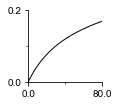

In [10]:
fig, ax = plt.subplots(figsize=(pw/5,pw/5))

ax.plot(total_g.light_power, total_g.g, lw=1, c='black')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlim(0,0.01)
ax.set_xticks([0, 0.01])
# light intensity in mW/mm2 -> lp (W) / (diam(um)/2)**2 / np.pi * 1e3 * 1e-6
ax.set_xticklabels([str(np.round(tick*1000/0.2**2/np.pi,0)) for tick in [0.,0.01]])
ax.set_xticks([0.005], minor=True)
ax.set_ylim(0,2e-10)
ax.set_yticks([0, 2e-10])
ax.set_yticklabels([str(tick*1e9) for tick in [0, 2e-10]])
ax.set_yticks([1e-10], minor=True)
fig.savefig('paper/NEW_FIGURES/FIG1/plots/light_power_vs_conductance.png', dpi=dpi, 
                facecolor=None, edgecolor=None, 
                bbox_inches='tight')

In [ ]:
fig, ax = plt.subplots(figsize=(pw/5,pw/5))

ax.plot(total_g.light_power.values[:-1], np.diff(total_g.g.values), lw=1, c='black')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
fig.savefig('paper/NEW_FIGURES/FIG1/plots/light_power_vs_conductance.png', dpi=dpi, 
                facecolor=None, edgecolor=None, 
                bbox_inches='tight')

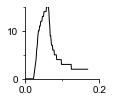

In [11]:
fig, ax = plt.subplots(figsize=(pw/5,pw/5))
plt.plot(total_g.g, total_g.APC, lw=1, c='black')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_ylim(0,15)
ax.set_yticks([0, 10])
ax.set_yticks([5, 15], minor=True)
ax.set_xlim(0,2e-10)
ax.set_xticks([0, 2e-10])
ax.set_xticklabels([str(tick*1e9) for tick in [0, 2e-10]])
ax.set_xticks([1e-10], minor=True)
fig.savefig('paper/NEW_FIGURES/FIG1/plots/conductance_vs_spikes.png', dpi=dpi, 
                facecolor=None, edgecolor=None, 
                bbox_inches='tight')

In [ ]:
# fl A 1       fl  2
A = 1
B = 2

gA = 3
gB = 1

gA*A-gB*B

In [ ]:
gA+=0.1
gB+=0.2
gA*A-gB*B